# Vanilla CNN 
Implementation of the Vanilla CNN described in the paper
Yue Wu and Tal Hassner, "Facial Landmark Detection with Tweaked Convolutional Neural Networks", arXiv preprint arXiv:1511.04031, 12 Nov. 2015. See project page for more information about this project. http://www.openu.ac.il/home/hassner/projects/tcnn_landmarks/

Written by Ishay Tubi : ishay2b [at] gmail [dot] com       https://www.linkedin.com/in/ishay2b
This script will create the data sets needed to train, test and validate Vanilla CNN.


In [1]:
# first lets set up the enviroment paths
import os , sys
import cv2 # Assume you have open cv python framework installed
import numpy as np

# Make sure dlib python path exists on PYTHONPATH else "pip install dlib" if needed.
import dlib
detector=dlib.get_frontal_face_detector() # Load dlib's face detector

# import helpers and classes used for the script - Assume the same path as existing notebook
from DataRow import DataRow, ErrorAcum, Predictor, getGitRepFolder, createDataRowsFromCSV, getValidWithBBox, writeHD5

# Either define CAFFE_ROOT in your enviroment variables or set it here
CAFFE_ROOT = os.environ.get('CAFFE_ROOT','~/caffe/distribute')  
sys.path.insert(0, CAFFE_ROOT + 'python')
import caffe

#Load project data paths, and pre calculated train data mean and std images.
ROOT = getGitRepFolder()  # ROOT is the git root folder .
sys.path.append(os.path.join(ROOT, 'python'))  # Assume git root directory
DATA_PATH = os.path.join(ROOT, 'data')
CSV_TEST  = os.path.join(ROOT, 'data', 'testImageList.txt')
CSV_TRAIN = os.path.join(ROOT, 'data', 'trainImageList.txt')

AFW_DATA_PATH = os.path.join(ROOT, 'data', 'testimages')
AFW_MAT_PATH = os.path.join(ROOT, 'data', 'anno-v7.mat')

PATH_TO_WEIGHTS  = os.path.join(ROOT, 'ZOO', 'vanillaCNN.caffemodel')
PATH_TO_DEPLOY_TXT = os.path.join(ROOT, 'ZOO', 'vanilla_deploy.prototxt')

MEAN_TRAIN_SET = cv2.imread(os.path.join(ROOT, 'trainMean.png')).astype('f4')
STD_TRAIN_SET  = cv2.imread(os.path.join(ROOT, 'trainSTD.png')).astype('f4')

MEAN_TRAIN_SET = cv2.imread(os.path.join(ROOT, 'trainMean.png')).astype('f4')
STD_TRAIN_SET  = cv2.imread(os.path.join(ROOT, 'trainSTD.png')).astype('f4')


from pickle import load, dump #We will use pickle to save and load data
from zipfile import ZipFile
from urllib import urlretrieve

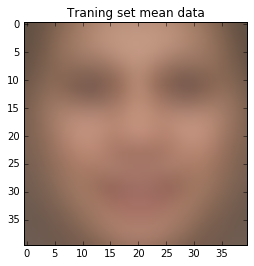

In [33]:
# Lets see the train data mean
MEAN_TRAIN_SET = cv2.imread(os.path.join(ROOT, 'trainMean.png')).astype('f4')
STD_TRAIN_SET  = cv2.imread(os.path.join(ROOT, 'trainSTD.png')).astype('f4')

%matplotlib inline
from matplotlib.pylab import *
imshow(cv2.cvtColor(MEAN_TRAIN_SET, cv2.COLOR_BGR2RGB).astype('uint8'))
title ("Training set mean data")

In [2]:
###########################    STEPS TO RUN       ####################
AFW_STEPS =['downloadAFW', 
            'createAFW_TestSet',
            'testAFW_TestSet'] # Steps needed for AFW

AFLW_STEPS=['downloadAFLW', 
            'testSetHD5', 
            'testSetPickle', 
            'testError',
            'trainSetHD5', 
            'createAFLW_TestSet', 
            'testAFLW_TestSet', 
            'testErrorMini'] # Steps needed for AFLW

STEPS =AFLW_STEPS+AFW_STEPS # Run AFLW and AFW steps


In [35]:
# Download AFLW train set

if 'downloadAFLW' in STEPS:
    theurl='http://mmlab.ie.cuhk.edu.hk/archive/CNN/data/train.zip'
    filename = ROOT+'/AFLW.zip'
    if os.path.isfile(filename):
        print "AFLW.zip training data already downloaded"
    else:
        print "Downloading "+theurl + " ....."
        name, hdrs = urlretrieve(theurl, filename)
        print "Finished downloading AFLW....."

    print 'Extracting zip data...'
    folderPATH = ROOT+'/data'
    with ZipFile(filename) as theOpenedFile:
        theOpenedFile.extractall(folderPATH)
        theOpenedFile.close()
    print "Done extracting AFLW zip folder"


Finished downloading AFLW.....
Extracting zip data...
Done extracting AFLW zip folder


In [36]:
if 'downloadAFW' in STEPS:
    theurl = 'https://www.ics.uci.edu/~xzhu/face/AFW.zip'
    filename = ROOT+'/AFW.zip'
    if os.path.isfile(filename):
        print "AFW.zip already downloaded"
    else:
        print "Downloading "+theurl + " ....."
        name, hdrs = urlretrieve(theurl, filename)
        print "Finished downloading AFW....."
        
    print "Extracting AFW zip file......"
    folderPATH = ROOT+'/data'
    with ZipFile(filename) as theOpenedFile:
        theOpenedFile.extractall(folderPATH)
        theOpenedFile.close()


Finished downloading AFW.....
Extracting AFW zip file......


In [37]:
# Create test set for caffe and python
if 'testSetHD5' in STEPS or 'testSetPickle' in STEPS:
    print "Creating test set....."
    dataRowsTest_CSV  = createDataRowsFromCSV(CSV_TEST , DataRow.DataRowFromNameBoxInterlaved, DATA_PATH)
    print "Finished reading %d rows from test" % len(dataRowsTest_CSV)
    dataRowsTestValid,R = getValidWithBBox(dataRowsTest_CSV)
    print "Original test:",len(dataRowsTest_CSV), "Valid Rows:", len(dataRowsTestValid), " noFacesAtAll", R.noFacesAtAll, " outside:", R.outsideLandmarks, " couldNotMatch:", R.couldNotMatch
    if 'testSetPickle' in STEPS:
        with open('testSet.pickle','w') as f:
            dump(dataRowsTestValid,f)
        print "Finished dumping to testSet.pickle"
        # Also save mini test set for debug
        with open('testSetMini.pickle','w') as f:
            dump(dataRowsTestValid[0:10],f)
        print "Finished dumping to testSetMini.pickle"
        
        
    if 'testSetHD5' in STEPS:
        writeHD5(dataRowsTestValid, ROOT+'/caffeData/hd5/test.hd5', ROOT+'/caffeData/test.txt', MEAN_TRAIN_SET, STD_TRAIN_SET)
        print "Finished writing test to caffeData/test.txt"



Creating test set.....
Finished reading 3466 rows from test
Original test: 3466 Valid Rows: 3431  noFacesAtAll 32  outside: 1  couldNotMatch: 2
Finished dumping to testSet.pickle
Finished dumping to testSetMini.pickle
Processing row 1 
Processing row 1001 
Processing row 2001 
Processing row 3001 
Processing row 3431 
Finished writing test to caffeData/test.txt


In [38]:
#Sanity check - test and plot mini batch
DEBUG = True
if 'testErrorMini' in STEPS:
    print "Running Sanity check"
    with open('testSetMini.pickle','r') as f:
        dataRowsTrainValid = load(f)
        
    testErrorMini=ErrorAcum()
    predictor = Predictor(protoTXTPath=PATH_TO_DEPLOY_TXT, weightsPath=PATH_TO_WEIGHTS)
    for i, dataRow in enumerate(dataRowsTrainValid):
        dataRow40 = dataRow.copyCroppedByBBox(dataRow.fbbox).copyMirrored()
        image, lm_0_5 = predictor.preprocess(dataRow40.image, dataRow40.landmarks())
        prediction = predictor.predict(image)
        testErrorMini.add(lm_0_5, prediction)
        dataRow40.prediction = (prediction+0.5)*40.  # Scale -0.5..+0.5 to 0..40
        
        if DEBUG:
            dataRow.prediction = dataRow40.inverseScaleAndOffset(dataRow40.prediction) # Scale up to the original image scale
            dataRow.show()
            if i>40:
                print "Debug breaked after %d rows:" % i
            

    print "Sanity check: Test Error mini:", testErrorMini


Running Sanity check
Sanity check: Test Error mini: 6.029048 mean error, 10 items, 0 failures  0.000000 precent


In [47]:
# Run the same caffe test set using python
DEBUG = False  # Set this to true if you wish to plot the images
if 'testError' in STEPS:
    with open('testSet.pickle','r') as f:
        dataRowsTrainValid = load(f)
        
    testError=ErrorAcum()
    predictor = Predictor(protoTXTPath=PATH_TO_DEPLOY_TXT, weightsPath=PATH_TO_WEIGHTS)
    for i, dataRow in enumerate(dataRowsTrainValid):
        dataRow40 = dataRow.copyCroppedByBBox(dataRow.fbbox)
        image, lm40 = predictor.preprocess(dataRow40.image, dataRow40.landmarks())
        prediction = predictor.predict(image)
        testError.add(lm40, prediction)
        dataRow40.prediction = (prediction+0.5)*40.
        
        if DEBUG and i%40 ==0:
            dataRow.prediction = dataRow40.inverseScaleAndOffset(dataRow40.prediction)
            dataRow.show()
            break
        
            
    print "Test Error:", testError


Test Error: 5.946673 mean error, 3431 items, 238 failures  0.069368 precent


In [40]:
# Create the traning set
if 'trainSetHD5' in STEPS:
    dataRowsTrain_CSV = createDataRowsFromCSV(CSV_TRAIN, DataRow.DataRowFromNameBoxInterlaved, DATA_PATH)
    print "Finished reading %d rows from training data. Parsing BBox...." % len(dataRowsTrain_CSV)
    dataRowsTrainValid,R = getValidWithBBox(dataRowsTrain_CSV)
    print "Original train:",len(dataRowsTrain_CSV), "Valid Rows:", len(dataRowsTrainValid), " No faces at all", R.noFacesAtAll, " Illegal landmarks:", R.outsideLandmarks, " Coult not math:", R.couldNotMatch
    dataRowsTrain_CSV=[]  # remove from memory
    
    writeHD5(dataRowsTrainValid, ROOT+'/caffeData/hd5/train.hd5', ROOT+'/caffeData/train.txt', MEAN_TRAIN_SET, STD_TRAIN_SET ,mirror=True)
    print "Finished writing train to caffeData/train.txt"
  

Finished reading 10000 rows from training data. Parsing BBox....
Original train: 10000 Valid Rows: 9848  No faces at all 142  Illegal landmarks: 6  Coult not math: 4
Processing row 1 
Processing row 1001 
Processing row 2001 
Processing row 3001 
Processing row 4001 
Processing row 5001 
Processing row 6001 
Processing row 7001 
Processing row 8001 
Processing row 9001 
Processing row 10001 
Processing row 11001 
Processing row 12001 
Processing row 13001 
Processing row 14001 
Processing row 15001 
Processing row 16001 
Processing row 17001 
Processing row 18001 
Processing row 19001 
Finished writing train to caffeData/train.txt


In [41]:
# AFW test - Make the pickle data set
if 'createAFW_TestSet' in STEPS:
    print "Parsing AFW anno-v7.mat ....."
    from scipy.io import loadmat
    annotaions = loadmat(AFW_MAT_PATH)['anno']
    dataRowsAFW = []
        
    for anno in annotaions:
        dataRow = DataRow.DataRowFromAFW(anno, AFW_DATA_PATH)
        if dataRow is not None:
            dataRowsAFW.append(dataRow)
    print "Finished parsing anno-v7.mat with total rows:", len(dataRowsAFW)
    annotaions = None  # remove from memory
    
    dataRowsAFW_Valid, R=getValidWithBBox(dataRowsAFW)
    print "Original AFW:", len(dataRowsAFW), "Valid Rows:", len(dataRowsAFW_Valid), " No faces at all", R.noFacesAtAll, " illegal landmarks:", R.outsideLandmarks, " Could not match:", R.couldNotMatch
    dataRowsAFW = None  # remove from Memory
    with open('afwTestSet.pickle','w') as f:
        dump(dataRowsAFW_Valid, f)
        print "Data saved to afwTestSet.pickle"


Parsing AFW anno-v7.mat .....
Finished parsing anno-v7.mat with total rows: 170
Original AFW: 170 Valid Rows: 141  No faces at all 15  illegal landmarks: 10  Could not match: 4
Data saved to afwTestSet.pickle


In [4]:
# Run AFW benchmark
DEBUG = False
if 'testAFW_TestSet' in STEPS:
    print "Running AFW benchmark....."
    with open('afwTestSet.pickle','r') as f:
        dataRowsAFW_Valid = load(f)

    testErrorAFW=ErrorAcum()
    predictor = Predictor(protoTXTPath=PATH_TO_DEPLOY_TXT, weightsPath=PATH_TO_WEIGHTS)
    for i, dataRow in enumerate(dataRowsAFW_Valid):
        dataRow40 = dataRow.copyCroppedByBBox(dataRow.fbbox)
        image, lm_0_5 = predictor.preprocess(dataRow40.image, dataRow40.landmarks())
        prediction = predictor.predict(image)
        testErrorAFW.add(lm_0_5, prediction)
        dataRow40.prediction = (prediction+0.5)*40.  # Scale -0.5..+0.5 to 0..40
        
        if DEBUG:
            dataRow.prediction = dataRow40.inverseScaleAndOffset(dataRow40.prediction) # Scale up to the original image scale
            dataRow.show()
            

    print "Test Error AFW:", testErrorAFW


Running AFW benchmark.....
Test Error AFW: 7.691730 mean error, 141 items, 28 failures  0.198582 precent


In [42]:
   

# Create the MTFL benchmark
if 'createAFLW_TestSet' in STEPS:  
    MTFL_LINK = 'http://mmlab.ie.cuhk.edu.hk/projects/TCDCN/data/MTFL.zip'
    MTFL_ZIP = ROOT+"/MTFL.zip"
    if os.path.isfile(MTFL_ZIP):
        print "MTFL.zip already downloaded"
    else:
        print "Downloading:"+MTFL_ZIP+" from url:"+MTFL_LINK+"....."
        urlretrieve(MTFL_LINK, MTFL_ZIP)
        print "Finished download. Extracting file....."
        with ZipFile(MTFL_ZIP) as f:
            f.extractall(ROOT+'/data')
            print "Done extracting MTFL"
            f.close()
            
    AFLW_PATH = os.path.join(ROOT,'data')
    CSV_MTFL = os.path.join(AFLW_PATH,'testing.txt')
    dataRowsMTFL_CSV  = createDataRowsFromCSV(CSV_MTFL , DataRow.DataRowFromMTFL, AFLW_PATH)
    print "Finished reading %d rows from test" % len(dataRowsMTFL_CSV)
    dataRowsMTFLValid,R = getValidWithBBox(dataRowsMTFL_CSV)
    print "Original test:",len(dataRowsMTFL_CSV), "Valid Rows:", len(dataRowsMTFLValid), " No faces at all", R.noFacesAtAll, " Illegal landmarks:", R.outsideLandmarks, " Could not match:", R.couldNotMatch
    with open('testSetMTFL.pickle','w') as f:
        dump(dataRowsMTFLValid,f)
    print "Finished dumping to testSetMTFL.pickle"        



Downloading:/Users/ishay/Dev/VanilaCNN/MTFL.zip from url:http://mmlab.ie.cuhk.edu.hk/projects/TCDCN/data/MTFL.zip.....
Finished download. Extracting file.....
Done extracting MTFL
error parsing  ['']
Finished reading 2995 rows from test
Original test: 2995 Valid Rows: 2535  No faces at all 244  Illegal landmarks: 209  Could not match: 7
Finished dumping to testSetMTFL.pickle


In [3]:
# Run AFLW benchmark
DEBUG = False
if 'testAFLW_TestSet' in STEPS:
    print "Running AFLW benchmark........."
    with open('testSetMTFL.pickle','r') as f:
        dataRowsAFW_Valid = load(f)
    print "%d rows in AFLW benchmark ....." % len(dataRowsAFW_Valid)
    testErrorAFLW=ErrorAcum()
    predictor = Predictor(protoTXTPath=PATH_TO_DEPLOY_TXT, weightsPath=PATH_TO_WEIGHTS)
    for i, dataRow in enumerate(dataRowsAFW_Valid):
        dataRow40 = dataRow.copyCroppedByBBox(dataRow.fbbox)
        image, lm_0_5 = predictor.preprocess(dataRow40.image, dataRow40.landmarks())
        prediction = predictor.predict(image)
        testErrorAFLW.add(lm_0_5, prediction)
        dataRow40.prediction = (prediction+0.5)*40.  # Scale -0.5..+0.5 to 0..40
        
        if DEBUG and i%40 == 0:
            dataRow.prediction = dataRow40.inverseScaleAndOffset(dataRow40.prediction) # Scale up to the original image scale
            dataRow.show()


    print "Test Error AFLW:", testErrorAFLW



Running AFLW benchmark.........
2535 rows in AFLW benchmark .....
Test Error AFLW: 8.313394 mean error, 2535 items, 562 failures  0.221696 precent


In [48]:
# Call caffe to train - Call this from bash 
# We disable the warning only becuase training aborts and disableing succedes.
os.chdir(ROOT+"/ZOO")  # Run this from ZOO filder due to local paths in prototxt
!caffe.bin train -solver ../ZOO/vanilla_adam_solver.prototxt 2>&1 | tee ../log.txt
os.chdir(ROOT)

I0226 23:00:03.841297 2061250560 caffe.cpp:177] Use CPU.
I0226 23:00:03.842597 2061250560 solver.cpp:48] Initializing solver from parameters: 
test_iter: 1000
test_interval: 5000
base_lr: 1e-05
display: 2500
max_iter: 1400000
lr_policy: "fixed"
momentum: 0.9
snapshot: 5000
snapshot_prefix: "../caffeData/snapshots/snap"
solver_mode: CPU
net: "./vanilla_train.prototxt"
momentum2: 0.999
type: "Adam"
I0226 23:00:03.843035 2061250560 solver.cpp:91] Creating training net from net file: ./vanilla_train.prototxt
I0226 23:00:03.843643 2061250560 net.cpp:322] The NetState phase (0) differed from the phase (1) specified by a rule in layer 
I0226 23:00:03.843668 2061250560 net.cpp:49] Initializing net from parameters: 
name: "vanila"
state {
  phase: TRAIN
}
layer {
  type: "HDF5Data"
  top: "X"
  top: "landmarks"
  include {
    phase: TRAIN
  }
  hdf5_data_param {
    source: "/Users/ishay/Dev/VanilaCNN/caffeData/train.txt"
    batch_size: 30
  }
}
layer {
  name: "Conv1"
  type: "Convolution"
 

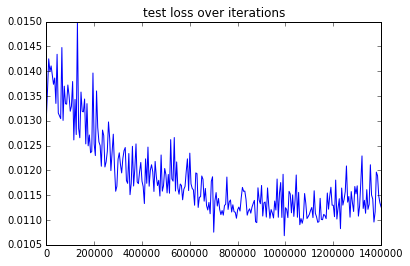

In [2]:
import sys
import re
%matplotlib inline

from matplotlib.pylab import show, title, plot

logFilePath = '../log.txt'
    
floatReg='[-+]?[0-9]*\.?[0-9]+([eE][-+]?[0-9]+)?'

regex       =re.compile('.* Iteration (\d+), Testing net \(#\d+\)')
regexLos    =re.compile('.*Test net output #0: loss = (%s) (\* 1 = %s loss)'%(floatReg,floatReg))
regexLos    =re.compile('.*Test net output #0: loss = (%s)'%(floatReg,))

found=0

xAxis=[]
yAxis=[]

with open(logFilePath) as f:
    global result
    for line in f:
        xresult = regex.search(line)
        if (xresult):
            xAxis.append(xresult.groups(1)[0])
            
        yresult = regexLos.search(line)
        if (yresult):
            yAxis.append(yresult.groups(1)[0])

mnSize = min(len(xAxis),len(yAxis))
skip = 0

xAxis = xAxis[skip:mnSize]
yAxis = yAxis[skip:mnSize]

plot(xAxis, yAxis)
title('test loss over iterations')
